<i><h1 style="text-align:center;color:#FFFFF">Análisis Jornadas Exploratorias 1° y 2° Medio 2021</h1></i>
<i><h3 style="text-align:center;color:#FFFFF">por : Christian Vergara Retamal</h3></i></i>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud, STOPWORDS # Librería para Nube de palabras
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords 
from textblob import TextBlob
from googletrans import Translator
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
#import Levenshtein
import re
from googletrans import Translator
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 60

In [3]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Prepracíon De Ambiente de Trabajo

In [4]:
df = pd.read_csv("file.csv")

In [5]:
df.head()

,Marca temporal,Correo,Establecimiento,Selecciona las actividades que te parecieron más interesantes,¿Qué te gustaría haber visto en las Jornadas Exploratorias?,En qué actividades te gustaría participar,Evalúa tu experiencia general en las Jornadas Exploratorias,Cuéntanos que te parecieron las Jornadas Exploratorias.
0,2021/09/09 6:01:13 p. m. GMT-3,valentinaquezada905@gmail.com,Liceo Hualañe,"Motivación, perseverancia y NEM;Proyecto de vi...",todo lo que queria ver lo vi,Talleres Prácticos;Charla con docentes y estud...,7,"me parecieron muy buenas, en lo personal me en..."
1,2021/09/09 6:01:39 p. m. GMT-3,aveloso020@gmail.com,Colegio Andes Talca,Hábitos y Técnicas de estudios;Proyecto de vid...,test vocacionales tal vez,Talleres Prácticos;Charla con docentes y estud...,6,"genial, me resolvieron dudas y me encantaron."
2,2021/09/09 6:01:52 p. m. GMT-3,sofia.orellana.carrasco@gmail.com,chilean eagles college las vizcachas,Proyecto de vida : Herramientas para decidir;D...,los diferentes temas de cada área,"Jornadas de ""Descubrimiento Vocacional""",5,muy entretenidas y fácil de entender
3,2021/09/09 6:01:53 p. m. GMT-3,martinzuniga.estudiante@hualaneduca.cl,Liceo Bicentenario Hualañé,Hábitos y Técnicas de estudios;Descubriendo Ci...,Un acercamiento más a detalle sobre una clase ...,Talleres Prácticos;Charla con docentes y estud...,7,"Bastante entretenidas, además de que aprendí m..."
4,2021/09/09 6:02:15 p. m. GMT-3,damarisneiraacevedo@gmail.com,Liceo Marta Donoso Espejo,"Motivación, perseverancia y NEM;Proyecto de vi...",Tipos de becas para la universidad,Talleres Prácticos;Conocer dependencias virtua...,6,Muy buenas


In [6]:
df.shape

(45, 8)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(45, 8)

In [9]:
df.columns

Index(['Marca temporal', 'Correo', 'Establecimiento',
       'Selecciona las actividades que te parecieron más interesantes',
       '¿Qué te gustaría haber visto en las Jornadas Exploratorias?',
       'En qué actividades te gustaría participar ',
       'Evalúa tu experiencia general en las Jornadas Exploratorias',
       'Cuéntanos que te parecieron las Jornadas Exploratorias.'],
      dtype='object')

### Modificación de columnas

In [10]:
df.rename(columns={"Marca temporal":"TimeStamp",
                   "Selecciona las actividades que te parecieron más interesantes": "TopActivities",
                  "¿Qué te gustaría haber visto en las Jornadas Exploratorias?": "queFalto",
                  "En qué actividades te gustaría participar ": "actividades_gustos",
                  "Evalúa tu experiencia general en las Jornadas Exploratorias": "calificacion",
                  "Cuéntanos que te parecieron las Jornadas Exploratorias.": "comentarios"}, inplace=True)

## Funciones

In [11]:
def plot_by_column(df, pregunta):
    aux_dict = df[pregunta].value_counts().to_dict()
    y = list(aux_dict.values())
    plt.barh(*zip(*aux_dict.items()))
    for index, value in enumerate(y):
        plt.text(value, index, str(value))
    plt.title('Comportamiento de respuestas de {}'.format(pregunta))
    plt.show()
    plt.tight_layout()

In [12]:
def Binarizer(df, col):
    dummy = pd.get_dummies(df[col].str.get_dummies(sep=';'), drop_first=True)
    df = df.drop(col, axis = 1) 
    df = pd.concat([df, dummy], axis=1)
    return df

In [13]:
def separateAnswers(df, var):
    df_aux = pd.DataFrame()
    df_aux[var] = df[var]
    #df_aux.var=df_aux.var.str.replace(' ', '', regex=False)

    df_aux = Binarizer(df_aux, var)

    lista_cols = list(df_aux.columns)
    lista_counts = []
    count = 0
    for col in df_aux.columns:
        for index, row in df_aux.iterrows():
            if row[col] == 1:
                count +=1
        lista_counts.append(count)
        count = 0

    dicti = dict(zip(lista_cols, lista_counts))

    dicti = {k: v for k, v in sorted(dicti.items(), key=lambda item: item[1])}
    return dicti

In [14]:
def plot_hist_custom(var, titulo = "por defecto"):
    tmp = var.dropna() # Borramos, si es que existen nulls
    plt.hist(tmp, color = 'dodgerblue')
    plt.title(titulo, size = 17)
    plt.axvline(tmp.mean(), color = 'tomato', linewidth = 2,
                linestyle = '--', label = 'Media de la variable')
    plt.legend()

In [15]:
def wordCloud(dataframe, pregunta, palabras):
    df_temp = pd.DataFrame()
    df_temp[pregunta] = df[pregunta]
    comment_words = ''
    stopwords = set(STOPWORDS)
    # Agregamos las palabras en español a las 'stopwords'
    stopwords.update(palabras)
    for val in df_temp[pregunta].values:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width=800, height=800, stopwords = stopwords, min_font_size= 10).generate(comment_words)
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [16]:
# Utilizamos el archivo 'sp_words', el cuál contiene palabras que se
# omitiran al generar el wordcloud. Por ej. 'de', 'un', 'una', 'y', etc.
spanish_words = open('sp_words.txt').read().splitlines()
stopwords_gral = set(STOPWORDS)
# Agregamos las palabras en español a las 'stopwords'
stopwords_gral.update(spanish_words)

## Preguntas

In [17]:
df.columns

Index(['TimeStamp', 'Correo', 'Establecimiento', 'TopActivities', 'queFalto',
       'actividades_gustos', 'calificacion', 'comentarios'],
      dtype='object')

----

### TimeStamp

----

### Correo

----

### Establecimiento

----

### Selecciona las actividades que te parecieron más interesantes

In [18]:
df_top_activities = df.copy()

In [19]:
graf_top_activities = separateAnswers(df_top_activities, "TopActivities")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


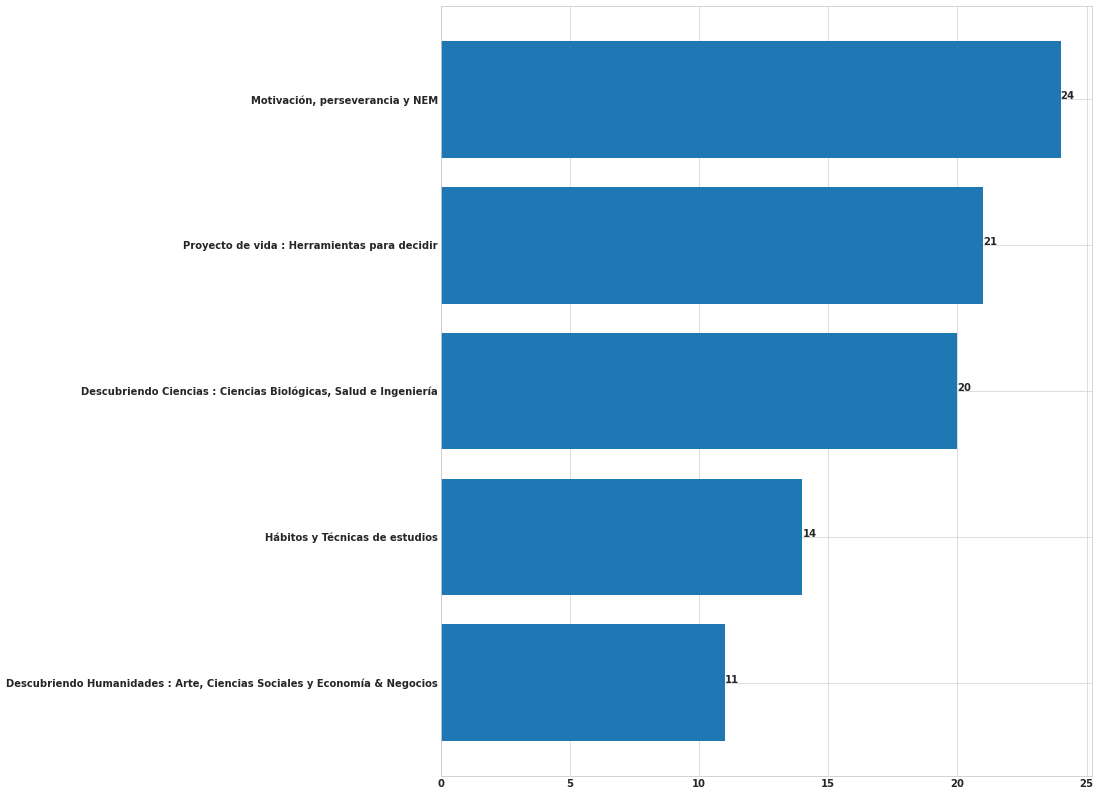

<Figure size 720x480 with 0 Axes>

In [20]:
plt.figure(figsize=(14,17))
plt.barh(*zip(*graf_top_activities.items()))
y = list(graf_top_activities.values())
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.title("")
plt.show()
plt.tight_layout()

----

### Qué te gustaría haber visto en las Jornadas Exploratorias

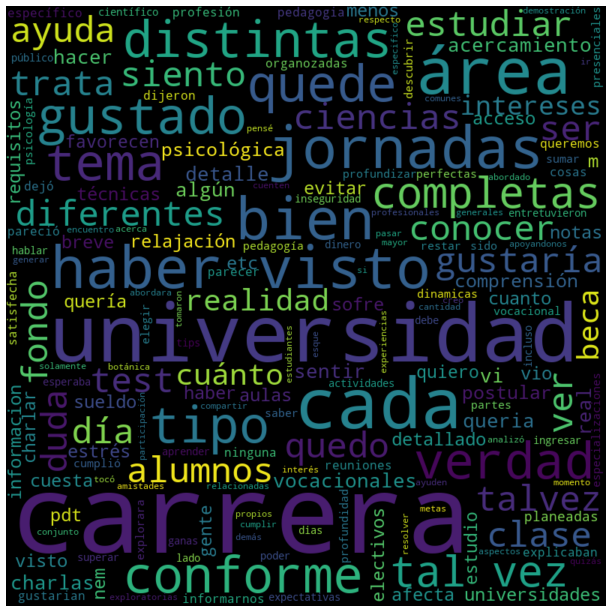

In [21]:
wordCloud(df, 'queFalto', spanish_words)

----

### En qué actividades te gustaría participar

In [22]:
df_actividades_gustos = df.copy()

In [23]:
graf_actividades_gustos = separateAnswers(df_actividades_gustos, "actividades_gustos")

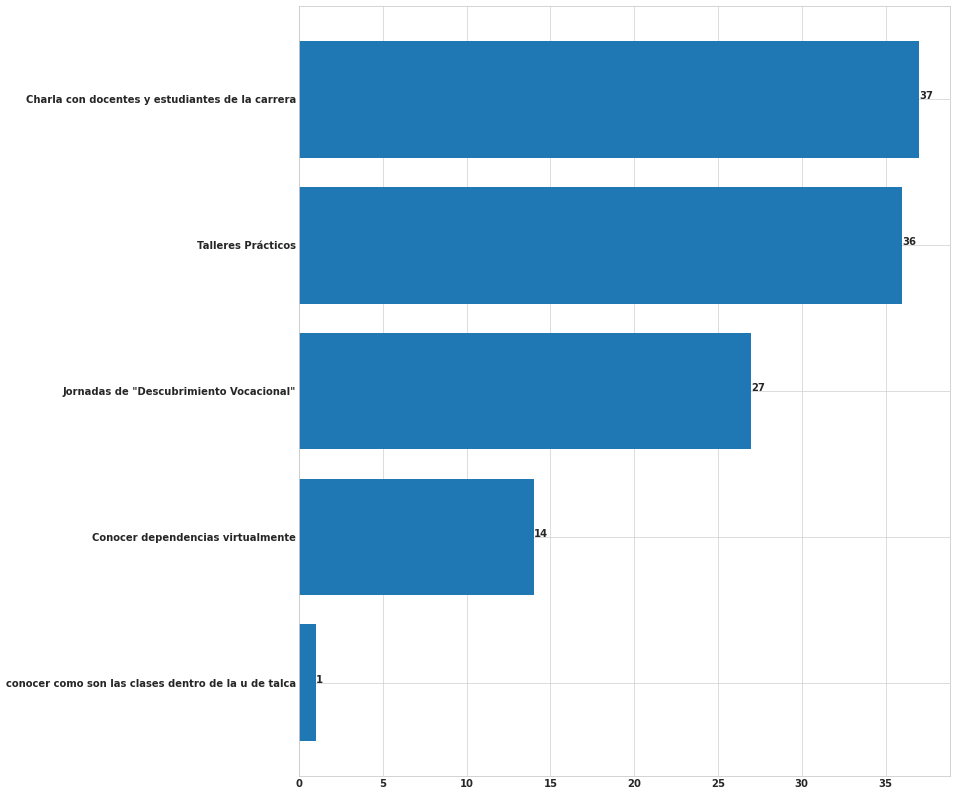

<Figure size 720x480 with 0 Axes>

In [24]:
plt.figure(figsize=(14,17))
plt.barh(*zip(*graf_actividades_gustos.items()))
y = list(graf_actividades_gustos.values())
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.title("")
plt.show()
plt.tight_layout()

----

### Evalúa tu experiencia general en las Jornadas Exploratorias

<AxesSubplot:>

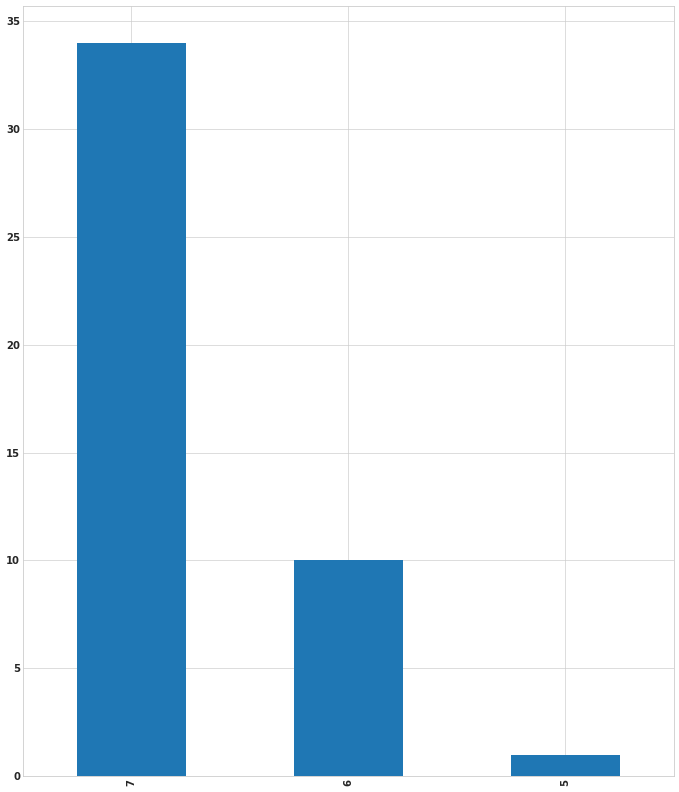

In [25]:
plt.figure(figsize=(14,17))
df['calificacion'].value_counts().plot(kind="bar")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


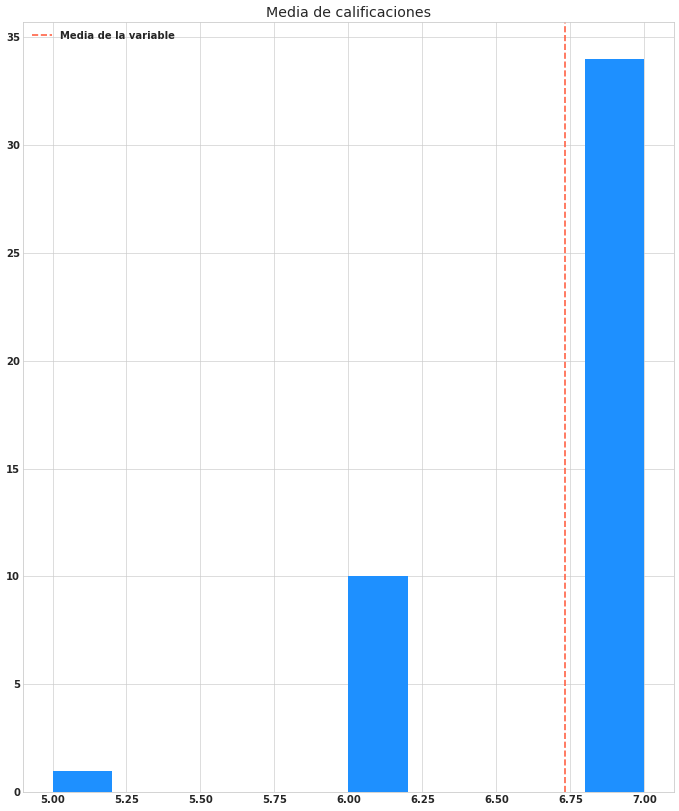

In [26]:
plt.figure(figsize=(14,17))
plot_hist_custom(df['calificacion'], 'Media de calificaciones')

----

### Cuéntanos que te parecieron las Jornadas Exploratorias

#### WordCloud

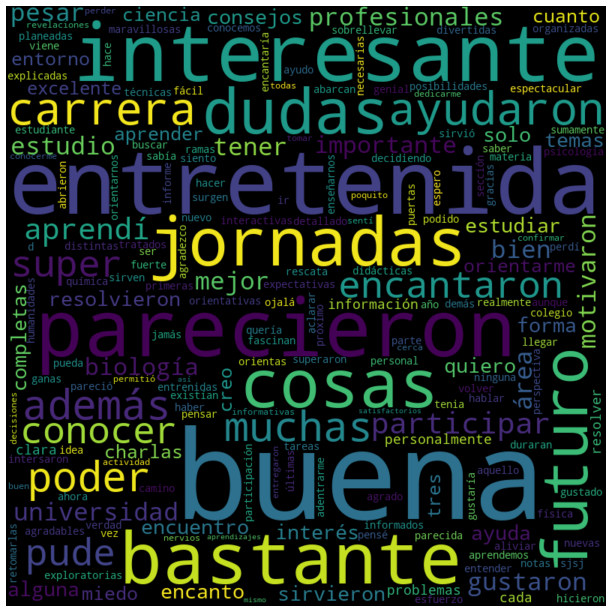

In [27]:
wordCloud(df, 'comentarios', spanish_words)

#### Análisis de Sentimientos

In [28]:
# Creamos dataframe de prueba 
df_comentario = pd.read_csv("comentarios_en.csv")

In [29]:
df_comentario.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [30]:
df_comentario.sample(7)

,comentario,comentario_en
27,"Me gustaron bastante, me resolvieron bastantes...","I liked them a lot, they solved many doubts I ..."
36,Me parecieron sumamente entretenidas y a la ve...,I found them extremely entertaining and at the...
8,Interesantes y buenas,Interesting and good
3,"Bastante entretenidas, además de que aprendí m...","Quite entertaining, plus I learned a lot of th..."
30,"Me gustaron mucho, aprendí muchas cosas, me si...","I liked them a lot, I learned many things, it ..."
37,A pesar de que no pude participar de todas las...,Although I was not able to participate in all ...
44,"Me ayudaron muchisimo, ademas agregar que todo...","They helped me a lot, in addition to adding th..."


In [31]:
#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in df_comentario['comentario_en']]
#add the sentiment metrics to the dataframe
df_comentario['tb_Pol'] = [b.sentiment.polarity for b in desc_blob]
#load VADER
analyzer = SentimentIntensityAnalyzer()
#Add VADER metrics to dataframe
df_comentario['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_comentario['comentario_en']]
df_comentario['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df_comentario['comentario_en']]
df_comentario['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df_comentario['comentario_en']]
df_comentario['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df_comentario['comentario_en']]

In [32]:
df_comentario

,comentario,comentario_en,tb_Pol,compound,neg,neu,pos
0,"me parecieron muy buenas, en lo personal me en...","I found them very good, personally I loved the...",0.622000,0.9061,0.000,0.601,0.399
1,"genial, me resolvieron dudas y me encantaron.","great, they solved my doubts and I loved them.",0.750000,0.8360,0.127,0.289,0.584
2,muy entretenidas y fácil de entender,very entertaining and easy to understand,0.541667,0.7474,0.000,0.386,0.614
3,"Bastante entretenidas, además de que aprendí m...","Quite entertaining, plus I learned a lot of th...",0.500000,0.4927,0.000,0.715,0.285
4,Muy buenas,Very good,0.910000,0.4927,0.000,0.238,0.762
5,Fueron entretenidas y de alguna forma ayuda el...,They were entertaining and in some way it help...,0.500000,0.6705,0.000,0.718,0.282
6,Interesantes y entretenidas.,Interesting and entertaining.,0.500000,0.6808,0.000,0.152,0.848
7,"Me pareció espectacular, fueron muy agradables...","I found it spectacular, they were very nice an...",0.626667,0.7233,0.000,0.569,0.431
8,Interesantes y buenas,Interesting and good,0.600000,0.6808,0.000,0.152,0.848
9,"Me encantaron, me motivaron mucho más de lo qu...","I loved them, they motivated me much more than...",0.487500,0.9153,0.000,0.644,0.356


Text(0, 0.5, 'Polaridad')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


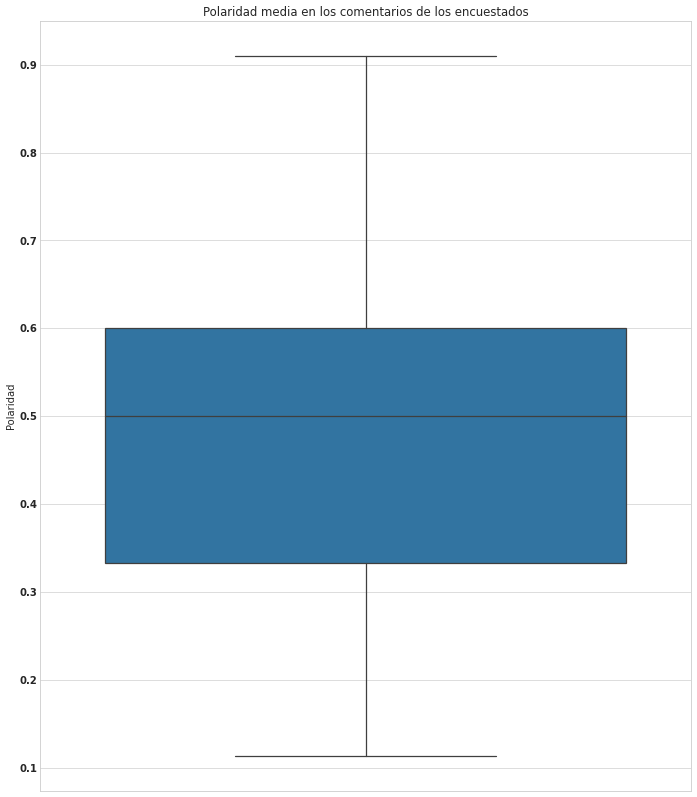

In [33]:
plt.figure(figsize=(14,17))
sns.boxplot(y=df_comentario["tb_Pol"])
plt.xticks([1], [""]);
plt.title("Polaridad media en los comentarios de los encuestados",size = 14)
plt.ylabel("Polaridad")

----